## Moving Average 

- Math 
- Codes 
- Model development 
- Coeefficinets and Log-likelihood 
- Residuals 
- Lags
- Check on Non-Stationar data 


**Simple MA (Moving Average) Mode**

$
r_t = C + \theta_1 \times \epsilon_{t-1} + \epsilon_t
$

- $ r_t$ - The value of $r$ in current period. 
- $\theta_1$ - A numeric coefficient for the value associated with the first lag
- $\epsilon_t$ - Residualss 
- $\epsilon_{t-1}$ - Previous residuals 


**Compute $\epsilon$**

$\epsilon_t$ = $Actual_t -Predicted_t$


**AR vs MA**

we can say a simple MA model is equivalent to an infinite AR model with certain restrictions, and inverse relation exists. An AR model uses the value of the variable while the model relies on the residual. To determine the number of lags, we relied on PACF, and ACF for MA models. The reason is the MA models aren't based on past period returns, therefore, determining which lagged values have a significant direct effect on the present day ones is not relevant.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
import statsmodels.tsa.stattools as sts
import seaborn as sns
sns.set()


Primary preprocessing 

In [2]:
raw_csv_data = pd.read_csv("./../datasets/Index2018.csv")
df = raw_csv_data.copy()
df.date = pd.to_datetime(df.date, dayfirst=True)
df.set_index("date", inplace=True)
df = df.asfreq('b')
df = df.fillna(method='ffill')


In [3]:
# picking market value for FTSE
df['market_value'] = df.ftse

df.drop(["spx", "ftse", "nikkei", "dax"], axis=1, inplace=True)
df.describe()


,market_value
count,6277.000000
mean,5423.679824
std,1145.616719
min,2876.600000
25%,4486.730000
50%,5663.300000
75%,6304.630175
max,7778.637689


Split the data 

In [4]:
train_locs = int(df.shape[0]*0.8)
train_locs


5021

In [5]:
df_train, df_test = df.iloc[:train_locs], df.iloc[train_locs:]
df_train, df_test


(            market_value
 date                    
 1994-01-07       3445.98
 1994-01-10       3440.58
 1994-01-11       3413.77
 1994-01-12       3372.02
 1994-01-13       3360.01
 ...                  ...
 2013-04-01       6411.74
 2013-04-02       6490.66
 2013-04-03       6420.28
 2013-04-04       6344.11
 2013-04-05       6249.77
 
 [5021 rows x 1 columns],
             market_value
 date                    
 2013-04-08   6276.940000
 2013-04-09   6313.200000
 2013-04-10   6387.370000
 2013-04-11   6416.140000
 2013-04-12   6384.390000
 ...                  ...
 2018-01-23   7731.827774
 2018-01-24   7643.428966
 2018-01-25   7615.839954
 2018-01-26   7665.541292
 2018-01-29   7671.533300
 
 [1256 rows x 1 columns])

**LLR Test**

In [6]:
def llr_test(model_one, model_two, df=1):
    l1 = model_one.fit().llf
    l2 = model_two.fit().llf
    lr = (2*(l2-l1))
    p = chi2.sf(lr, df).round(3)
    return p

Creating returns 

In [7]:
df['returns'] = df.market_value.pct_change(1)*100

**ACF Returns** 

It gives us an idea to how many lags we should use in our model.

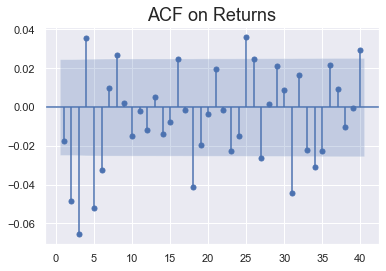

In [8]:
sgt.plot_acf(df.returns[1:], zero=False, lags=40)
plt.title("ACF on Returns", size=18)
plt.show()

### MA (1) for Returns

In [13]:
model_ret_ma_1 = ARIMA(df.returns[1:], order=(0,0,1))
result_ret_ma_1 = model_ret_ma_1.fit()
result_ret_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6276
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -9597.598
Date:                Thu, 18 Aug 2022   AIC                          19201.195
Time:                        14:33:09   BIC                          19221.429
Sample:                    01-10-1994   HQIC                         19208.206
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.014      1.355      0.175      -0.008       0.046
ma.L1         -0.0196      0.007     -2.608      0.009      -0.034      -0.005
sigma2         1.2468      0.011    113.239      0.000       1.225       1.268
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             10493.92
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We can notice that the coefficient for the one lag ago residual is significant at the 10 percent level, but not at the five percent level. This shouldn't come as a surprise since the first coefficient of the ACF was also not significantly different from zero. However, all other coefficients up to six lags ago fell outside the blue area, which suggests significance. In addition, the 8th and the 18th lags, we're also significant, as were some others, more than 20 periods ago. Since we expect the compound effects to decrease the further back in time we go, we can disregard the 18th lag and all significant periods that follow it.


**Lets go higher lags for MA model**

In [14]:
model_ret_ma_2 = ARIMA(df.returns[1:], order=(0,0,2))
result_ret_ma_2 = model_ret_ma_2.fit()
result_ret_ma_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6276
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -9589.839
Date:                Thu, 18 Aug 2022   AIC                          19187.677
Time:                        14:41:26   BIC                          19214.655
Sample:                    01-10-1994   HQIC                         19197.025
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.013      1.418      0.156      -0.007       0.045
ma.L1         -0.0254      0.008     -3.333      0.001      -0.040      -0.010
ma.L2         -0.0488      0.007     -7.037      0.000      -0.062      -0.035
sigma2         1.2438      0.011    112.219      0.000       1.222       1.266
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):             10264.12
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
llr_test(model_ret_ma_1, model_ret_ma_2)

0.0

What we notice is that the p value for the error term two periods ago is significant, which is expected from our ACF plot. However, you can see the p value for the one period ago, residual is now also significant. The MA (2) results and LLR test decide that the MA(2) model is better than MA(1)

In [16]:
model_ret_ma_3 = ARIMA(df.returns[1:], order=(0,0,3))
result_ret_ma_3 = model_ret_ma_3.fit()
result_ret_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6276
Model:                 ARIMA(0, 0, 3)   Log Likelihood               -9573.494
Date:                Thu, 18 Aug 2022   AIC                          19156.988
Time:                        14:46:25   BIC                          19190.710
Sample:                    01-10-1994   HQIC                         19168.672
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.013      1.500      0.134      -0.006       0.044
ma.L1         -0.0175      0.008     -2.296      0.022      -0.032      -0.003
ma.L2         -0.0539      0.007     -7.704      0.000      -0.068      -0.040
ma.L3         -0.0749      0.007    -10.835      0.000      -0.088      -0.061
sigma2         1.2373      0.011    108.084      0.000       1.215       1.260
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              9297.07
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
model_ret_ma_7 = ARIMA(df.returns[1:], order=(0,0,7))
result_ret_ma_7 = model_ret_ma_7.fit()
result_ret_ma_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6276
Model:                 ARIMA(0, 0, 7)   Log Likelihood               -9559.715
Date:                Thu, 18 Aug 2022   AIC                          19137.430
Time:                        14:47:49   BIC                          19198.130
Sample:                    01-10-1994   HQIC                         19158.461
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.012      1.525      0.127      -0.005       0.043
ma.L1         -0.0201      0.008     -2.472      0.013      -0.036      -0.004
ma.L2         -0.0490      0.007     -6.842      0.000      -0.063      -0.035
ma.L3         -0.0680      0.007     -9.432      0.000      -0.082      -0.054
ma.L4          0.0311      0.008      4.101      0.000       0.016       0.046
ma.L5         -0.0506      0.007     -7.049      0.000      -0.065      -0.036
ma.L6         -0.0305      0.008     -3.858      0.000      -0.046      -0.015
ma.L7          0.0076      0.008      0.958      0.338      -0.008       0.023
sigma2         1.2319      0.012    104.236      0.000       1.209       1.255
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              8907.53
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
model_ret_ma_9 = ARIMA(df.returns[1:], order=(0,0,9))
result_ret_ma_9 = model_ret_ma_9.fit()
result_ret_ma_9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6276
Model:                 ARIMA(0, 0, 9)   Log Likelihood               -9557.583
Date:                Thu, 18 Aug 2022   AIC                          19137.166
Time:                        14:50:04   BIC                          19211.355
Sample:                    01-10-1994   HQIC                         19162.871
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.013      1.476      0.140      -0.006       0.044
ma.L1         -0.0199      0.008     -2.421      0.015      -0.036      -0.004
ma.L2         -0.0492      0.007     -6.811      0.000      -0.063      -0.035
ma.L3         -0.0694      0.007     -9.583      0.000      -0.084      -0.055
ma.L4          0.0331      0.008      4.341      0.000       0.018       0.048
ma.L5         -0.0525      0.007     -7.211      0.000      -0.067      -0.038
ma.L6         -0.0310      0.008     -3.889      0.000      -0.047      -0.015
ma.L7          0.0079      0.008      0.998      0.318      -0.008       0.023
ma.L8          0.0255      0.008      3.081      0.002       0.009       0.042
ma.L9         -0.0032      0.008     -0.398      0.690      -0.019       0.012
sigma2         1.2310      0.012    103.561      0.000       1.208       1.254
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              8842.16
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

So the MA(9) model produces a non significant coefficient and fails the test. This is exactly shown in ACF.

#### Residuals for returns 

In [23]:
df['res_rest_ma_9'] = result_ret_ma_9.resid[1:]

In [27]:
round(df.res_rest_ma_9.mean(),3)


-0.0

In [29]:
round(df.res_rest_ma_9.var(),3)


1.231

The results we get are a mean of 0.0 and a variance of 1.23. Since variance is squared standard deviation, we can determine a standard deviation of 1.23. Gaussian white noise implies normality so we can use the 68, 95, 99.7 rule (Normality). This dictates what part of the data is spread within one, two and three standard deviations from the mean in either direction. Thus, we expect that most return residuals will be between -3.7 and 3.7. This means that worst case scenario, we could be up to 8 percentage points off when predicting
the returns for a market index. Of course, this is far from ideal, since 8 percent can make all the difference when it comes to profits and losses.

**Lets examine the Residual plot**

Whether it resembles a white noise or not !!

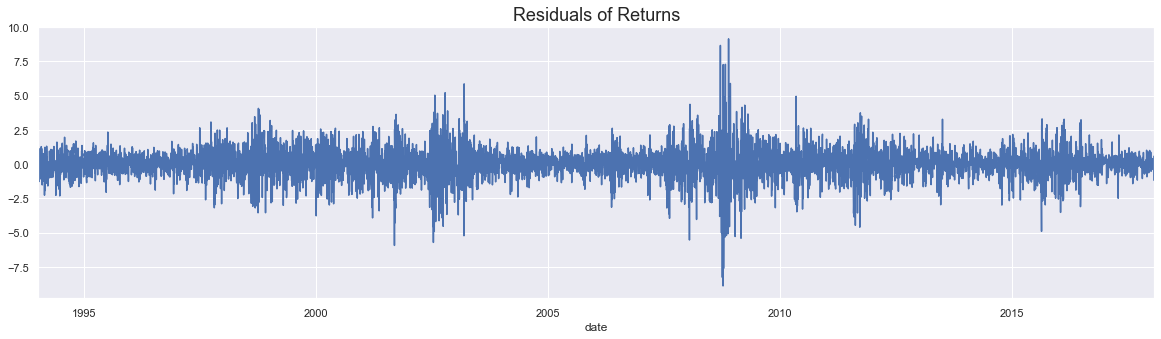

In [30]:
df.res_rest_ma_9.plot(figsize=(20, 5))
plt.title('Residuals of Returns', size=18)
plt.show()


if the data is non stationary, it can't be considered white noise. Thus we run the adjusted Deqi fuller test.

In [33]:
sts.adfuller(df.res_rest_ma_9[2:])

(-79.1964744636243,
 0.0,
 0,
 6274,
 {'1%': -3.4313927123850956,
  '5%': -2.8620007867175294,
  '10%': -2.5670152737839897},
 19024.014016785528)

It is indeed stationary, p-value is 0.0. Even though we got our desired result from the test, stationary is not the same as white noise. So we should also examine the ACF of the residuals.

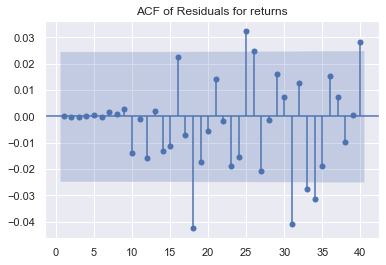

In [35]:
sgt.plot_acf(df.res_rest_ma_9[2:], zero=False, lags=40)
plt.title("ACF of Residuals for returns")
plt.show()


After running the plot ACF method, we can see that most of the coefficients are not significant.In particular, none of the first 17 lags are significant. The first eight of them are incorporated into the model, so it's not surprising they are essentially zero. However, the following nine lags are also insignificant, and this is a testament to how well our model performs. The further back in time we go, the less relevant the values and the errors become. Hence, significant coefficients, some 18 lags ago shouldn't play a major role in estimations.
This stems from the fact that markets adjust to shocks so values far in the past lose relevance.